In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib
import time

In [2]:
plot_gp_prior(4, n=20)

NameError: name 'plot_gp_prior' is not defined

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [4]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [5]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


In [6]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [7]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [8]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
    return lang1, lang2

In [9]:
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])

    return result_pt, result_en

In [10]:
MAX_LENGTH = 40

In [11]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [12]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [13]:
train_dataset.shape

AttributeError: 'PrefetchDataset' object has no attribute 'shape'

In [29]:
pt_batch, en_batch = next(iter(val_dataset))
en_batch

<tf.Tensor: shape=(64, 40), dtype=int64, numpy=
array([[8087,   98,   25, ...,    0,    0,    0],
       [8087,   12,   20, ...,    0,    0,    0],
       [8087,   12, 5453, ...,    0,    0,    0],
       ...,
       [8087,   18, 2059, ...,    0,    0,    0],
       [8087,   16, 1436, ...,    0,    0,    0],
       [8087,   15,   57, ...,    0,    0,    0]])>

In [38]:
predicted_sentence = tokenizer_en.decode([i for i in en_batch[5, :] 
                                            if i < tokenizer_en.vocab_size])  

In [37]:
predicted_sentence

'did they eat fish and chips ?'

In [50]:
predicted_sentence = tokenizer_pt.decode([i for i in pt_batch[0, :] 
                                            if i < tokenizer_pt.vocab_size])  

In [51]:
predicted_sentence

'tinham comido peixe com batatas fritas ?'

In [54]:
for (batch, (inp, tar)) in enumerate(train_dataset):
    print('inp: ', inp[0, :])
    print('tar: ', tar[0, :])
    print('tar: ', tar[1, :])
    continue

inp:  tf.Tensor(
[8214   70  267    4 3146 2683    4  651 4194 5995 8069    2 8215    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   19    8    9   35 2010 3465   11 5707 2856    2 8088    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0], shape=(33,), dtype=int64)
tar:  tf.Tensor(
[8087   10   31   34   68 6770  117    2 8088    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0], shape=(33,), dtype=int64)
inp:  tf.Tensor(
[8214   25  269    4 1555    1  167 6745   30    5  227    9 6874  989
    2 8215    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   23  266   12 3137  104   99  108   12  102    5 6472 

inp:  tf.Tensor(
[8214    8   20  128    5   27  916  649    6 1968 1663  431  168    2
 8215    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087    4  169    1   12  527   27 1649    1    4   24 7429   49  419
    3  151   27 1649    2 8088    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087   18   29   13    3 1617 2057 1914 7930    1 6751   33 8088    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
inp:  tf.Tensor(
[8214   13   56    5   66   13 4056  697 1051    1 2532 4797 7990    4
  470 6279    7   16 5145   12 7227    2 8215    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(38,), dtype=int64)
tar:  tf.Tensor(
[8087   17 

inp:  tf.Tensor(
[8214  886 5420    3   13    8 6501    2 8215    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087 1899  152  113   13   36 7451    2 8088    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(38,), dtype=int64)
tar:  tf.Tensor(
[8087  326    1  190    8    9   24    7  135  120   48    3  986    6
   40    2 8088    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(38,), dtype=int64)
inp:  tf.Tensor(
[8214  104    1 2927  201 8003  161    1 5078  314    1 3495    2 8215
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)
tar:  tf.Tensor(
[8087  254   17 5698 7946 

inp:  tf.Tensor(
[8214   47    8    5   13 3851  345   29 8215    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(38,), dtype=int64)
tar:  tf.Tensor(
[8087  154   13   16   36 1044   33 8088    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   61  144   31   14  456   33 8088    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
inp:  tf.Tensor(
[8214  229    4   10 1035  343 4317 7990   11 1164   20  298 1692 8073
 1561 2617   17   24   98 4412    2 8215    0    0    0    0    0    0
    0    0    0    0    0    0], shape=(34,), dtype=int64)
tar:  tf.Tensor(
[8087   14  132   45 5130 7238 

inp:  tf.Tensor(
[8214   25 1462  482 1265 8215    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)
tar:  tf.Tensor(
[8087   23 4033  167  988 8088    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)
tar:  tf.Tensor(
[8087 1426  119  489  136   92   23  266   14 1702 2419 7863  992    5
 4689  781    1  255   14  195   54  120  158    4  252  116   98   14
   85   16  204  515 8088    0    0    0    0], shape=(37,), dtype=int64)
inp:  tf.Tensor(
[8214   24 1934    1 2047   10 1016    5   13   56   33  553    2 8215
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087   11 1388    1   12  250    3 1848 

inp:  tf.Tensor(
[8214   52   13  488  492  374    2 8215    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   16   97   36  684  788  285  524 7877 8088    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(38,), dtype=int64)
tar:  tf.Tensor(
[8087   23   11    3 1820    8 1529 7946    1  174  266    3 2044 2907
 4417    1    3 6508 7863   13 7495 1362 1965   60 3250 2256  113 3051
  235    4 1954  497 1616 2990    2 8088    0    0], shape=(38,), dtype=int64)
inp:  tf.Tensor(
[8214   40   18   45   31 2353   14   20  464  154    4 1245 6551 7990
 5227 4910    1  191   18   45 3571  169    2 8215    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087   59   57 

inp:  tf.Tensor(
[8214   12  691  733 2788  200 8003  161    2 8215    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(36,), dtype=int64)
tar:  tf.Tensor(
[8087   69  594 2632  944   55  679    2 8088    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087   23   29   44   17   72 4332   33 8088    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
inp:  tf.Tensor(
[8214  264 6205 8003   38   16 2845  302    9 4219 7990    6  275 4267
 7990  579  623    4   55  142  128  327    2 8215    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(38,), dtype=int64)
tar:  tf.Tensor(
[8087    4   18   12 2498   44 

inp:  tf.Tensor(
[8214 1673  112   43  876 3271 2597    4  160    7  168    2 8215    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   14  271   11   47    6    3  926 2834    9   11    3  150    2
 8088    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087   17   20    7  619   11    3  879 7656 7863 3586 7863    6    7
 2085   82   20   32  469   11 1766  822    1    4   64   72 2777  175
   27  128  646    4    7 3035 2428 2728 7952    2 8088], shape=(39,), dtype=int64)
inp:  tf.Tensor(
[8214    6  557    1   13   56    9 5028 7990   14  598   11   64 1466
   25   56    9 5028 7990    5  885   75 1031   14  166    3   86  218
    2 8215    0    0    0    0    0    0    0], shape=(37,), dtype=int64)
tar:  tf.Tensor(
[8087    4   15 

inp:  tf.Tensor(
[8214   32  280  146   19  371  420 5102   51 2343  108   21    3 1671
 6827 6917    5  280    7  391 2771 5304 7990   26 5506 2116 8215    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   19    8    9   37  144    7  247    6   76 3671 1715   37    3
 1081 6215  757   10  344   76  982 7491 1434    2 8088    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   59   12   85 3680 3530    4 2338 7876  242 7876  598    9   11
    7 1826    1   12   24    5  746   77   61    5  405  100 2599    2
 8088    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
inp:  tf.Tensor(
[8214  375 1667   48  356 1816   40    3 4911 8069    1  235   29 8215
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tens

inp:  tf.Tensor(
[8214   67   92   65 3838  708 1394   59 2340 7990  269    4 1795    2
 8215    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0], shape=(33,), dtype=int64)
tar:  tf.Tensor(
[8087   94  119   92   12   98 7941 7870   26  101   16 1137  393   12
 6871 7931    2 8088    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0], shape=(35,), dtype=int64)
tar:  tf.Tensor(
[8087   18  315   44   14   31  290 7228  104   69 7235  283   58 1267
  605 5773 7946   33 8088    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0], shape=(35,), dtype=int64)
inp:  tf.Tensor(
[8214 1535   57   10 7316 7990    5 3841   91 6907 7835 7990    4 6684
 8073    2 8215    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)
tar:  tf.Tensor(
[8087   14  237   45 4130    4   17  867 7507  516    2 8088    0    0
    0    0    0    0

inp:  tf.Tensor(
[8214  372    2 8215    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087  153   51    2 8088    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087 2313 1050 2486 3591 7863   13 4336 7863  148  598    1    4  128
 5197   13   54 3695   46  202 2216  612 4706    2 8088    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
inp:  tf.Tensor(
[8214   21 1214  230 8003   38 4178   29 8215    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)
tar:  tf.Tensor(
[8087   61   88 

inp:  tf.Tensor(
[8214   24  215    1   87 1423 7245 7990   47   13 4418    2 8215    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   11  259    1  105    8   41 2019 6602   66   25   30 7941 7870
   26 2064    2 8088    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   23   71 7941 7870   26   17   34 1002    5   24   16 3488 2498
    4    5  846    7   57    5 3998   11   69 2985 2858 2419 7863 4362
 5005    1    4   34  247    6    3  700    6 3202   33 8088], shape=(40,), dtype=int64)
inp:  tf.Tensor(
[8214 1008 1098    1 1268   14  158  208  327  932 8215    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)
tar:  tf.Tensor(
[8087 

inp:  tf.Tensor(
[8214   47   62    7   78 3655    1   63  405 3784    2 8215    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0], shape=(35,), dtype=int64)
tar:  tf.Tensor(
[8087   66   14   24    3  168 5142 7939   56   14   39  102 2348    2
 8088    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087   47 6198 7863  431  508    2 8088    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
inp:  tf.Tensor(
[8214    3  143   49   14  166    3  962    1 1613  166    3  962    2
 8215    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087  219   13 1392    1 

inp:  tf.Tensor(
[8214    6  100  785   85  399 1635    6 3738 6548 8055    1   62   54
 5053 2256 7990    4  218    2 8215    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087    4   11    7  720   95 1060 5158 7863    4 7082 2725    1   96
   14   24   39   16 1002 4682    6  199    2 8088    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   23  111    1 1816   64   22  126  490    6  765    3 3495 7932
    1  204   33 8088    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
inp:  tf.Tensor(
[8214   24  850    4  507  927    1 3830 7990    5    8   10   43 7341
  226   26 7721 7990    3 7864 8072    2 8215    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[

inp:  tf.Tensor(
[8214   25   10  133    8 5993    2 8215    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   23   47  173   13 1349    2 8088    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   19    8    9   53   73   48 2522 7863 3933    9    5    3 4969
    2 8088    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
inp:  tf.Tensor(
[8214  194    1   54    8    3 5793   83    4  428  802 5271 8066    1
    5    8    3 2137    1    7  428  565  638  505    6    7  428 1447
    2 8215    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf

inp:  tf.Tensor(
[8214   32   16  282   79   12  162  495 2524 8073   51 1402 1786  861
  268  673 8003  832 8003  178   37 8215    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   44   15  102   76 1362  961    9    5  120  645  660    1  133
    1   25 1485    2 8088    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   25 1585    7  691 7928    1    7 7005 7863 4171    1  144   53
 2779 3038 7946    2 8088    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
inp:  tf.Tensor(
[8214    7    5   74   79    8    5  286  142   18 5863   17    4 7230
 8069    5    4 7107   34   26 2005 8073    2 8215    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(38,), dtype=int64)
tar:  tf.Tensor(
[

inp:  tf.Tensor(
[8214   18   45 3330  200    2 8215    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087   57 1712  161    2 8088    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   17  545    7  135  421    5   85   43 4453  947    1   23 7936
    8  164  340    5 1006   17   11  476 6523    2 8088    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
inp:  tf.Tensor(
[8214  119    1   48  699    5 2677   57    3 7906    1 5482    1 2169
    1    3 7647  429  178 8003  318    2 8215    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(38,), dtype=int64)
tar:  tf.Tensor(
[8087 

inp:  tf.Tensor(
[8214   42    8 6004  295   23    5 2819 1293    2 8215    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087   60  185 3173   16   13  657    2 8088    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087    3  243 2253  696 7353 7863   11    3  322 1377 4324 7947    1
   15   97   36   34 3668    5 1606    1  134    7  666  163 1327    6
  118    2 8088    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
inp:  tf.Tensor(
[8214    6 2268 8055    1  278  354    1    8    3 2317   28   33  212
    2 8215    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087 

inp:  tf.Tensor(
[8214 2646 8073    1   25 5815  651   36  726 3203   81  244    1 1275
 6990 3552    1    6 1060   50  560    7    5    8    5 1251    2 8215
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087 5443   23  845 1965   60    3 6448 7946    1   15 4047   27   76
  526    4 3258 7863    5  724   29   86   54  925    2 8088    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   19    8    9 1069    1   15  184  100  105    8   41   48 4425
 2633 6119    8 7946    2 8088    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
inp:  tf.Tensor(
[8214    7    5    8    5  257  230  197   27 2156 8003   94    7    5
  629    6   47    7 1700    2 8215    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(36,), dtype=int64)
tar:  tf.Tensor(
[8087   18 

inp:  tf.Tensor(
[8214 1478    5  188 6995   12   12 6220 5769    5 6570    2 8215    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   25  258   15  207 2369    3 6269    6  108   82 1193    2 8088
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087   17   20 1330  155  177   12   70 2831 5340   55   48    3   93
    5 7091    2 8088    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
inp:  tf.Tensor(
[8214   85    8    5   27 3106  197    7    5   95    3  488   29 8215
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(36,), dtype=int64)
tar:  tf.Tensor(
[8087   95   20 7936 

inp:  tf.Tensor(
[8214   48  699    5 3259    7   19  547    1    7  813 6244 4701  112
  146 3685 7990   15 2025    1    9 3993 7990  153   12 1746    2 8215
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   37   12  172   77    6    3  429    1 1361  155 6871    9   38
    7 1267 7435  152    1    7 2875 7863  249  171    2 8088    0    0
    0    0    0    0    0    0    0    0], shape=(36,), dtype=int64)
tar:  tf.Tensor(
[8087  169    1   21  269    1  145   13    7  275 1602    6 2311  566
   38   45 2374  591 6634 4914 3270    2 8088    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(36,), dtype=int64)
inp:  tf.Tensor(
[8214   25 3501    3 5487 7990   43  301   22 1548    4  259  117 6036
    4  160    7  168    2 8215    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)
tar:  tf.Tensor(
[8087   19    8    9  103  305 1752  873   99 

inp:  tf.Tensor(
[8214    6   16   61   13  312 2214    1   56   11   12 2740 8072    1
 1557  147    2 8215    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087    4   44   65   98   36  184  161    1   17   20    6  647    5
 1628  161    2 8088    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087 7936    8   78 3764   60 4006 7863 2999    5  296 7503 7863   10
  184 1407    2 8088    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
inp:  tf.Tensor(
[8214  149    7 2810    8  897 1058 1505  597   37 8215    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087 

inp:  tf.Tensor(
[8214    7 5096 7990 5556  716  591 8003   16    3  297    1    6   27
 5556  716  595 8003   38   41 5096    2 8215    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087    3 1918 7863 7032 3114    9  131    1    4   12 7032 3114 7863
    3 1918    2 8088    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087    4   89    6   17   97  120  158    5    3  575 3321    2 8088
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
inp:  tf.Tensor(
[8214    6   21 4054    1    7 7814 4705    4 2892   17   82 5108   30
    5   66 5728   90    7 1098    2 8215    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(36,), dtype=int64)
tar:  tf.Tensor(
[8087    4   37    7 2114 

inp:  tf.Tensor(
[8214  104    1   52    8    9  154    4 7310 1699    2 8215    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087  133    1   19    8    9   16  166    6 7558    2 8088    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   12  103   84   10    3  124 6114    6    3 5186  338   22   73
    5  638   11    3 1864    1   95   19    8    9 5294 2557    5 3039
   16 2452   99 1223    1 2720    5 3985 7863 4769    2 8088], shape=(40,), dtype=int64)
inp:  tf.Tensor(
[8214  118   34    9 3554 1738  670  201 8069    1   46  208  189    4
  115 1056    1    5 7086   50  726 1508 5116  129    4 1410    2 8215
    0    0    0    0    0    0    0    0    0    0], shape=(38,), dtype=int64)
tar:  tf.Tensor(
[8087 

inp:  tf.Tensor(
[8214    6   72  985   41 1817    2 8215    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087    4   17  446    3  109  123  947    2 8088    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(36,), dtype=int64)
tar:  tf.Tensor(
[8087   94  136  192 8088    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(36,), dtype=int64)
inp:  tf.Tensor(
[8214   53   21   16   13   38 7882   50  277    1   21   16    9  477
  389    4 5969 6625   38 2372    3 4509 8072    2 8215    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   17   20   37   44   25 

inp:  tf.Tensor(
[8214 7592 3957  132   14 4042    1 7706   19  135 6292    2 8215    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(36,), dtype=int64)
tar:  tf.Tensor(
[8087 3985 4064   46   99 2592    1 5349 2638   60 1221    2 8088    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087    4   25 3220  114 3694 7518    2 8088    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
inp:  tf.Tensor(
[8214   25   13  125  326  938  874  619  101   16   13 4567   57  270
    7 2228  261    5   62   22 4433    2 8215    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(38,), dtype=int64)
tar:  tf.Tensor(
[8087   23   14 1066 7941 7870 

inp:  tf.Tensor(
[8214  149   53    3 5778    1   13   53 2258   28 6674  586   39 7997
 1048 8067  646 4903  299    7  625 3671 2056   91  153  176  954 6993
 2651   37 8215    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087  314  284 1306    1   98 7941 7870   26   85 1000   52   12 1221
 7931 3807 1123 7950  710 7870 7863 3902 7863 4266  249  126 1490   55
 1269    2 8088    0    0    0    0    0    0], shape=(37,), dtype=int64)
tar:  tf.Tensor(
[8087   16  863   13   45  863    6   45 4214 7863 3933    1   91   13
   83   37 7375  492   37    3 2702 5175 3933 7863   13  223    2 8088
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)
inp:  tf.Tensor(
[8214  308    5   52 2270   10 2601   68   35 3321    4   10  311   11
    3 2297   29 8215    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087  149   10  296    7 7431 

inp:  tf.Tensor(
[8214  299 1197   50    4  666 1139 2196 4249  169 8003   16 7378   17
 3189  362 8215    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087  634   15  468  485 3642 3955  829 1456  511 4406 7946  297 8088
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087  876   21 1062   56 2505 7653 2556    2 8088    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
inp:  tf.Tensor(
[8214   59  395 1439 3009 7990   72 5641 7990    9 1677   22 2275   99
    2 8215    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[

inp:  tf.Tensor(
[8214 1115  107   65  155    1   16   27 3166 7990   80 1789  924  671
  128 1277  387    1   27  375  687  711  104    1    5  339 1789  924
  671  142   18 1277  226    4 7465 2898  250  436 8215    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087 1426  136   92  111    1   44   12  102    5   54  166    6  134
    7 2280  497   38 1649    1   12  203  443  384  133    1   29   35
  509    7  129   38   39    6  779 1861  321  798 8088], shape=(39,), dtype=int64)
tar:  tf.Tensor(
[8087  344   17    7  157 2557    5  201    7 6078 7863   87   79    2
 8088    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int64)
inp:  tf.Tensor(
[8214    6  339   21 2218  862  255 8215    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(38,), dtype=int64)
tar:  tf.Tensor(
[8087   15 

tar:  tf.Tensor(
[8087  146   47    6  100  337   93   25 1281   19    2 8088    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)
inp:  tf.Tensor(
[8214  194    1    8    9  661   33  417    4 2514 8072    2 8215    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   18   19    8    9    7   68  407  726    5 3950    2 8088    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)
tar:  tf.Tensor(
[8087   58   22    3 2658  113   57   11 2099    2 8088    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)
inp:  tf.Tensor(
[8214    6    3 1565    1    3 1846 

tar:  tf.Tensor(
[8087 1314  913 4647 7863   13    7 2982  173    5  197    2 8088    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0], shape=(35,), dtype=int64)
tar:  tf.Tensor(
[8087    3 5962 5169    5 5829  104 2412  198   11    3 1574 1179 3805
    2 8088    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0], shape=(35,), dtype=int64)
inp:  tf.Tensor(
[8214    6 1416 5148 4027  554    3 5682 7990 3926   83   20   18  448
   94  141 3911  281    1    6  720 5166 2923  435    2 8215    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087    4 2172  432  696   86  182   16 2275 3451 7863   10 7936    8
   78   54   73    5 3855   15    4  229   17 2904    2 8088    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int64)
tar:  tf.Tensor(
[8087   29   71   15   24   36  685   87 

tar:  tf.Tensor(
[8087 1259 3923 7863 2187 4597  175    3  360    6   18  138    6   43
 1086 4201   49  368   82   22 6540 7863    5 2018    1   91   13  154
   14  468  107  737    7 4587  894    2 8088], shape=(37,), dtype=int64)
tar:  tf.Tensor(
[8087   94  136  192 8088    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)
inp:  tf.Tensor(
[8214   25   13    8  192  131  506    2 8215    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0], shape=(38,), dtype=int64)
tar:  tf.Tensor(
[8087   23   19    8    9   36   10 1069    2 8088    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(37,), dtype=int64)
tar:  tf.Tensor(
[8087   17 5879  175   57    5 1543    2 8088 

In [35]:
predicted_sentence

'i was always worried about being caught and sent back .'

In [39]:
predicted_sentence

"and from what i feel , it 's a cure for me , but for us all ."

In [31]:
tokenizer_en.decode(en_batch[0, 1:])

ValueError: Received id 8088 which is invalid. Ids must be within [0, 8087).

In [23]:
en_batch[0:4, 1: ]

<tf.Tensor: shape=(4, 39), dtype=int64, numpy=
array([[  98,   25, 1037, 1903,    4, 7283,   33, 8088,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  12,   20,  260, 5796,   35,  183, 2955,    4, 1565,  380,    2,
        8088,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  12, 5453,   47,   28,    3, 3176, 1960,    6,    7, 3730, 1560,
        7863,   59, 1148, 3254, 7947,    2, 8088,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  23,   12,   84,   16,   13,  367, 1917, 1923, 1071, 7932,    2,
        8088,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
    

In [55]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [61]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [62]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

(1, 50, 512)


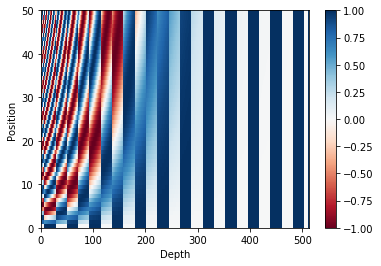

In [63]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [64]:
# the mask indicates which entries should not be used.
# we are using this to avoid both padding with zeros as input and look ahead mask to avoid
# future values as input 


In [65]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [260]:
x = tf.constant( [[1, 2, 3, 0, 0]])
create_padding_mask(x)

<tf.Tensor: shape=(1, 1, 1, 5), dtype=float32, numpy=array([[[[0., 0., 0., 1., 1.]]]], dtype=float32)>

In [262]:
inp[0, :]

<tf.Tensor: shape=(40,), dtype=int64, numpy=
array([8214,  167,  210,    1, 3452,   79,   21,  527,    2, 8215,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])>

In [263]:
inp.shape

TensorShape([64, 40])

In [287]:
tar.shape

TensorShape([64, 40])

In [286]:
create_look_ahead_mask(tar)

InvalidArgumentError: dims must represent a vector, got shape [2,64,40] [Op:Fill]

In [134]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    print(tf.shape(mask))
    return mask  # (seq_len, seq_len)

In [309]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

tf.Tensor([3 3], shape=(2,), dtype=int32)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [69]:
x

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.36658216, 0.36618853, 0.5617776 ]], dtype=float32)>

In [70]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  # The mask is multiplied with -1e9 (close to negative infinity). 
  # This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. 
  # The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [312]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [72]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [73]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [74]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [ ]:
train_dataset

In [75]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        
#         print('value: ', v)
#         print('key: ', k)
#         print('query: ', q)
        
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [76]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [77]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [78]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [79]:
# The input sentence is passed through N encoder layers 
# that generates an output for each word/token in the sequence.

# The decoder attends on the encoder's output and
# its own input (self-attention) to predict the next word.


In [80]:
# Encoder layer

# Each encoder layer consists of sublayers:

# Multi-head attention (with padding mask)
# Point wise feed forward networks.

In [81]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [82]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [83]:
# Decoder layer

# Each decoder layer consists of sublayers:

# Masked multi-head attention (with look ahead mask and padding mask)
# Multi-head attention (with padding mask). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublayer.
# Point wise feed forward networks

In [136]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, 
           combined_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, combined_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        # residual connection
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [137]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [138]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
#         print('encoder_x_inp: ', x)
#         print('encoder_mask: ', mask)

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
#         print('encoded_x_after_embedding: ', x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [139]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [216]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    #a call method, the layer's forward pass
    def call(self, tar_inp, enc_output, training, 
           combined_mask, padding_mask):

        seq_len = tf.shape(tar_inp)[1]
        attention_weights = {}

        x = self.embedding(tar_inp)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 combined_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [217]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [239]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar_inp, training, enc_padding_mask, 
           combined_mask, dec_padding_mask):
        
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar_inp, enc_output, training, combined_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [240]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

In [241]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [242]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

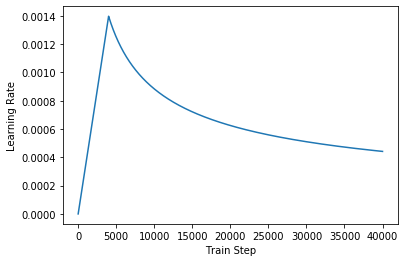

In [243]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [244]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')



In [267]:
aa.shape

TensorShape([64, 1, 1, 40])

In [275]:
aa[0,:, :, :]

<tf.Tensor: shape=(1, 1, 40), dtype=float32, numpy=
array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1.]]], dtype=float32)>

In [245]:
# Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [246]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [247]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [248]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [276]:
def create_masks(inp, tar):
    
    
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1]) # if max seq length is 40 -- > this will be 40X40 
    ## this will be batch_size X 1 X 1 X 40
    dec_target_padding_mask = create_padding_mask(tar)
    
    ## This will also be (64, 1, 40, 40)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    ### example output:
    
# bb[60, :, : , 5]
# Out[308]:
# <tf.Tensor: shape=(1, 40), dtype=float32, numpy=
# array([[1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
#         0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>
    
    
    return enc_padding_mask, combined_mask, dec_padding_mask

In [292]:
create_padding_mask(tar)

<tf.Tensor: shape=(64, 1, 1, 40), dtype=float32, numpy=
array([[[[0., 0., 0., ..., 1., 1., 1.]]],


       [[[0., 0., 0., ..., 1., 1., 1.]]],


       [[[0., 0., 0., ..., 1., 1., 1.]]],


       ...,


       [[[0., 0., 0., ..., 1., 1., 1.]]],


       [[[0., 0., 0., ..., 1., 1., 1.]]],


       [[[0., 0., 0., ..., 1., 1., 1.]]]], dtype=float32)>

In [314]:
bb = tf.maximum(create_look_ahead_mask(tf.shape(tar)[1]), create_padding_mask(tar))

tf.Tensor([36 36], shape=(2,), dtype=int32)


In [318]:
tar.shape

TensorShape([31, 36])

In [320]:
bb[30, :, : , :]

<tf.Tensor: shape=(1, 36, 36), dtype=float32, numpy=
array([[[0., 1., 1., ..., 1., 1., 1.],
        [0., 0., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]]], dtype=float32)>

In [288]:
create_look_ahead_mask(tf.shape(tar)[1])

tf.Tensor([40 40], shape=(2,), dtype=int32)


<tf.Tensor: shape=(40, 40), dtype=float32, numpy=
array([[0., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [277]:
# Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every n epochs.


checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [278]:
# The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. 
# tar_real is that same input shifted by 1: 
#     At each location in tar_input, tar_real contains the next token that should be predicted.

In [279]:
# For example, sentence = "SOS A lion in the jungle is sleeping EOS"

# tar_inp = "SOS A lion in the jungle is sleeping"

# tar_real = "A lion in the jungle is sleeping EOS"

In [280]:
# Teacher forcing is passing the true output to the next time step
# regardless of what the model predicts at the current time step.

In [281]:
# To prevent the model from peaking at the expected output the model uses a look-ahead mask.

In [282]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)



    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [283]:
EPOCHS = 1

In [284]:
import sys

In [310]:
train_dataset

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.int64, tf.int64)>

In [210]:
sess = tf.compat.v1.InteractiveSession()

In [313]:
for (batch, (inp, tar)) in enumerate(train_dataset):
    print(tar.shape)

(64, 39)
(64, 40)
(64, 35)
(64, 39)
(64, 36)
(64, 39)
(64, 35)
(64, 40)
(64, 37)
(64, 39)
(64, 37)
(64, 38)
(64, 37)
(64, 39)
(64, 35)
(64, 40)
(64, 39)
(64, 38)
(64, 39)
(64, 39)
(64, 38)
(64, 38)
(64, 40)
(64, 39)
(64, 40)
(64, 39)
(64, 32)
(64, 40)
(64, 37)
(64, 40)
(64, 40)
(64, 40)
(64, 38)
(64, 40)
(64, 38)
(64, 38)
(64, 36)
(64, 39)
(64, 39)
(64, 40)
(64, 40)
(64, 38)
(64, 39)
(64, 37)
(64, 37)
(64, 40)
(64, 38)
(64, 40)
(64, 37)
(64, 35)
(64, 36)
(64, 40)
(64, 37)
(64, 38)
(64, 39)
(64, 38)
(64, 36)
(64, 40)
(64, 38)
(64, 38)
(64, 37)
(64, 39)
(64, 35)
(64, 39)
(64, 35)
(64, 35)
(64, 38)
(64, 37)
(64, 40)
(64, 40)
(64, 36)
(64, 40)
(64, 38)
(64, 39)
(64, 40)
(64, 38)
(64, 39)
(64, 38)
(64, 39)
(64, 40)
(64, 37)
(64, 39)
(64, 40)
(64, 39)
(64, 39)
(64, 38)
(64, 39)
(64, 40)
(64, 40)
(64, 40)
(64, 37)
(64, 37)
(64, 40)
(64, 38)
(64, 37)
(64, 30)
(64, 38)
(64, 39)
(64, 37)
(64, 35)
(64, 39)
(64, 36)
(64, 40)
(64, 38)
(64, 40)
(64, 37)
(64, 36)
(64, 38)
(64, 39)
(64, 38)
(64, 38)
(

In [285]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
              epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Tensor("Shape_1:0", shape=(2,), dtype=int32)
[[[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]


 ...


 [[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]]
Epoch 1 Batch 0 Loss 8.9930 Accuracy 0.0000
[[[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]


 ...


 [[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]]
[[[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]


 ...


 [[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]]
[[[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]


 ...


 [[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]]
[[[[0 0 0 ... 0 0 0]]]


 [[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]


 ...


 [[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]]
[[[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]


 ...


 [[[0 0 0 ... 1 1 1]]]


 [[[0 0 0 ... 1 1 1]]]



KeyboardInterrupt: 

In [ ]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]

    # inp sentence is portuguese, hence adding the start and end token
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
  
    predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
  
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [101]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: 
Real translation: this is a problem we have to solve .


In [ ]:
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')


In [18]:
# Every v1.Session.run call should be replaced by a Python function.
# The feed_dict and v1.placeholders become function arguments.
# The fetches become the function's return value.
# After that add a tf.function decorator to make it run efficiently in graph. 